### Import Libraries

In [2]:
import pandas as pd
import re
import string
import nltk
import emoji
import csv
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from qalsadi import lemmatizer
from googletrans import Translator
from matplotlib import pyplot as plt
import seaborn as sns


nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nadaa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nadaa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nadaa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Load train data 

In [3]:
file_path = 'train.xlsx'
train = pd.read_excel(file_path)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32036 entries, 0 to 32035
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   review_description  32036 non-null  object
 1   rating              32036 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 500.7+ KB


In [5]:
train.head()

,review_description,rating
0,شركه زباله و سواقين بتبرشم و مفيش حتي رقم للشك...,-1
1,خدمة الدفع عن طريق الكي نت توقفت عندي اصبح فقط...,1
2,تطبيق غبي و جاري حذفه ، عاملين اكواد خصم و لما...,-1
3,فعلا تطبيق ممتاز بس لو فى امكانية يتيح لمستخدم...,1
4,سيء جدا ، اسعار رسوم التوصيل لا تمت للواقع ب ص...,-1


# EDA

### Sentiment Distribution

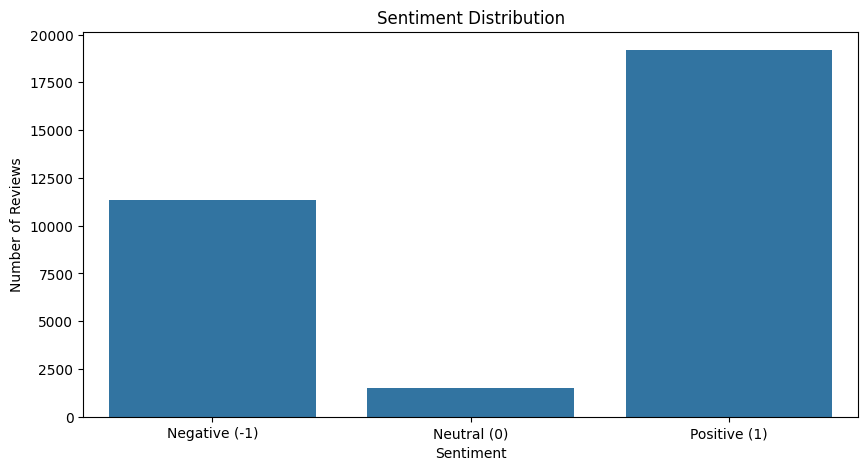

In [6]:
sentiment_counts = train['rating'].value_counts()

# Plotting the sentiment distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.xticks(ticks=[0, 1, 2], labels=['Negative (-1)', 'Neutral (0)', 'Positive (1)'])
plt.show()

### Review Length Distribution

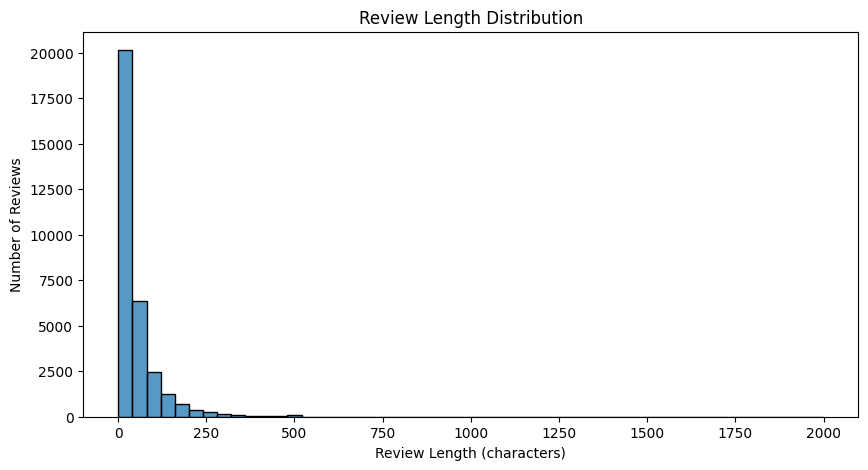

In [7]:
# Review Length Analysis
review_length = train['review_description'].apply(len)

# Plotting the distribution of review lengths
plt.figure(figsize=(10, 5))
sns.histplot(review_length, bins=50)
plt.title('Review Length Distribution')
plt.xlabel('Review Length (characters)')
plt.ylabel('Number of Reviews')
plt.show()

### Emojis Distribution

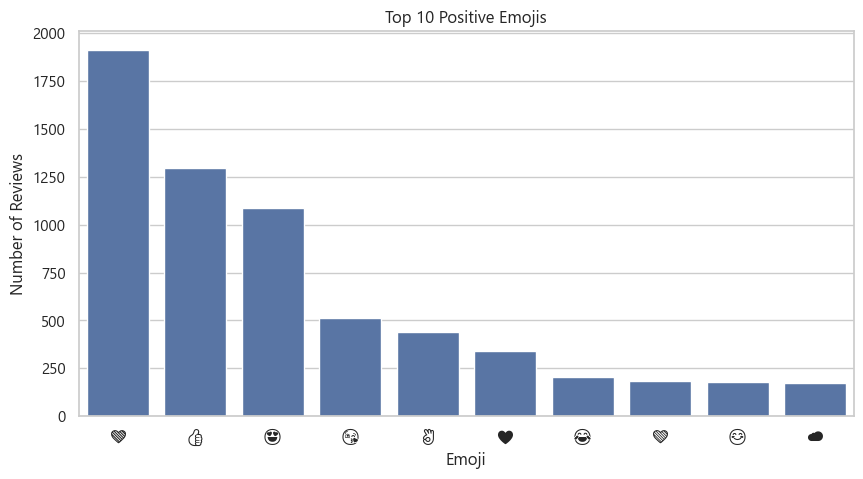

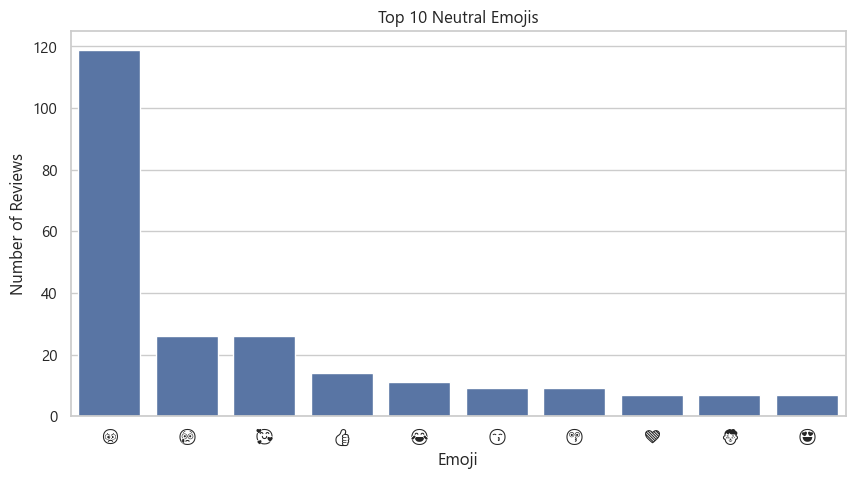

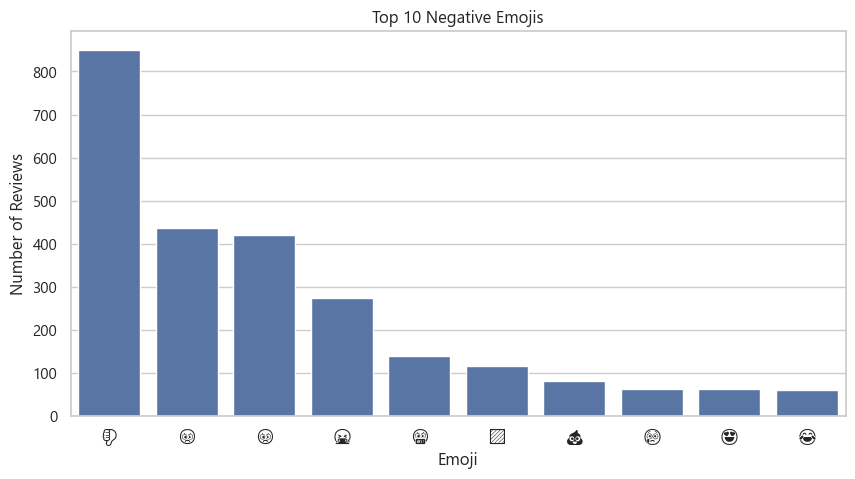

In [8]:
# Get emoji list
emoji_list = emoji.UNICODE_EMOJI['en'].keys()

# Function to extract emojis from text
def extract_emojis(text):
    return [c for c in text if c in emoji_list]

# Create separate DataFrames for each sentiment
positive_reviews = train[train['rating'] == 1]['review_description']
neutral_reviews = train[train['rating'] == 0]['review_description']
negative_reviews = train[train['rating'] == -1]['review_description']

# Extract emojis from reviews
positive_emojis = positive_reviews.apply(extract_emojis)
neutral_emojis = neutral_reviews.apply(extract_emojis)
negative_emojis = negative_reviews.apply(extract_emojis)

# Function to generate top emojis bar plot
def generate_top_emojis_bar_plot(emojis, title):
    emoji_counts = {}
    for emoji_list in emojis:
        for emoji in emoji_list:
            emoji_counts[emoji] = emoji_counts.get(emoji, 0) + 1
    sorted_emojis = dict(sorted(emoji_counts.items(), key=lambda item: item[1], reverse=True)[:10])
    
    # Set a font that includes emoji characters
    sns.set(style="whitegrid", font="Segoe UI Emoji")
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(sorted_emojis.keys()), y=list(sorted_emojis.values()))
    plt.title(title)
    plt.xlabel('Emoji')
    plt.ylabel('Number of Reviews')
    plt.show()

# Generate emoji bar plots for each sentiment
generate_top_emojis_bar_plot(positive_emojis, 'Top 10 Positive Emojis')
generate_top_emojis_bar_plot(neutral_emojis, 'Top 10 Neutral Emojis')
generate_top_emojis_bar_plot(negative_emojis, 'Top 10 Negative Emojis')

### Basic preprocessing

##### Checking for null values

In [9]:
train.isnull().sum()

review_description    0
rating                0
dtype: int64

In [10]:
def remove_nulls_and_duplicates(df):
    df_cleaned = df.dropna()
    df_cleaned = df_cleaned.drop_duplicates()
    return df_cleaned

### Cleaning text

In [11]:
def remove_punctuation(text):
    punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ''' + string.punctuation
    text = re.sub('[%s]' % re.escape(punctuations), ' ', text)
    return text

In [12]:
def remove_digits(text):
    return re.sub('\d+', '', text)

In [13]:
def remove_diacritics(text):
    return re.sub(r"[ًًٌٍَُِّْ]", "", text)

In [14]:
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("[يى]", "ي", text) 
    text = re.sub("[ؤئ]", "ء", text) 
    text = re.sub("ة", "ه", text)
    text = re.sub("ـ", "", text)
    text = re.sub("گ", "ك", text)
    return text

In [15]:
def remove_repeating_char(text):
    # Remove 3+ repeated consecutive characters
    return re.sub(r'(.)\1{2,}', r'\1', text)

In [16]:
def remove_long_words(text, threshold=15):
    return ' '.join(word for word in text.split(" ") if len(word) < threshold)

In [17]:
def remove_non_arabic_words(text):
    """
    Source: https://gist.github.com/mohabmes/33b724edfd4f0f3ec2e6644168db516e#file-preprocess_arabic_text-py-L22
    """
    return re.sub(r'[^\u0600-\u06ff\u0750-\u077f\ufb50-\ufbc1\ufbd3-\ufd3f\ufd50-\ufd8f\ufd50-\ufd8f\ufe70-\ufefc\uFDF0-\uFDFD]+', ' ', text)

#### Remove stopwords

In [18]:
stopwords_list = set(stopwords.words("english") + stopwords.words("arabic"))
words_to_keep = {'not', 'لا', 'ليس', 'مش', 'لم', 'لن', 'جدا', 'اكثر', 'قليل', 'كثير', 'حب', 'بكره', 'بحب', 'عجب', 'غير', 'كره'}
stopwords_list = stopwords_list.difference(words_to_keep)
len(stopwords_list)

874

In [19]:
def remove_stopwords(text):
    text = ' '.join([word for word in word_tokenize(text) if word not in stopwords_list])
    return text

#### Replace emojis

In [20]:
"""
Source:
https://github.com/a-ibrahimi/Arabic-Emojipedia
https://stackoverflow.com/a/76419165/13218954
"""
def build_emoji_dictionary():
    csv_file = 'emojis.csv'
    emoji_dict = {}
    with open(csv_file, 'r', encoding='utf-8') as file:
        reader = csv.reader(file)
        for row in reader:
            emoji = row[0]
            text = row[1]
            emoji_dict[emoji] = text
    return emoji_dict

# def replace_emojis(text):
#     emoji_dict = build_emoji_dictionary()
#     emojis = emoji.emoji_list(text)
#     for emo in emojis:
#         if emo['emoji'] in emoji_dict:
#             # Replace the emoji with the corresponding text surrounded by spaces
#             text = text.replace(emo['emoji'], ' ' + emoji_dict[emo['emoji']] + ' ')
#     return text

def replace_emojis(text):
    emoji_dict = build_emoji_dictionary()
    demojized_text = emoji.demojize(text)
    emojis = [e for e in demojized_text.split() if e.startswith(':') and e.endswith(':')]
    
    for emo in emojis:
        emoji_char = emoji.emojize(emo)
        if emoji_char in emoji_dict:
            # Replace the emoji with the corresponding text surrounded by spaces
            text = text.replace(emoji_char, ' ' + emoji_dict[emoji_char] + ' ')
    return text

#### Translate non-Arabic words

In [21]:
translator = Translator()

#### Lemmatization

In [22]:
arabic_lemmatizer = lemmatizer.Lemmatizer()

In [23]:
def lemmatize_word(word):
    try:
        language = translator.detect(word).lang
    except:
        return word
    
    if language == 'en':
        try:
            translated_word = translator.translate(word, src='en', dest='ar').text
            if translated_word in stopwords_list:
                # to be removed later
                return word
            word = translated_word
        except:
            return word

    try:
        lemma = arabic_lemmatizer.lemmatize(word)
        return lemma
    except:
        return word

def lemmatize_multilingual_text(text):
    lemmatized_words = [lemmatize_word(word) for word in text.split()]
    return ' '.join(lemmatized_words)

In [24]:
def preprocess(text):
    text = str(text).lower()
    text = remove_punctuation(text)
    text = remove_digits(text)
    text = remove_diacritics(text)
    text = normalize_arabic(text)
    text = remove_repeating_char(text)
    text = remove_long_words(text)
    text = remove_stopwords(text)

    text = replace_emojis(text)
    # Remove unhandled emojis/invalid characters
    text = re.sub(r'[^\w\s]','', text)
    # Collapse any consecutive spaces to a single space
    text = re.sub('\s+', ' ', text).strip()
    text = lemmatize_multilingual_text(text)
    # Remove any not-translated non-arabic word
    text = remove_non_arabic_words(text)
    # Normalize again as some words have inconcsistent data from lemmatization  
    text = remove_diacritics(text)
    text = normalize_arabic(text)   
    text = remove_stopwords(text)
 
    return text

## Clean train data

In [24]:
def clean_df(df):
    # utf-8 encoding
    df['preprocessed_review'] = df['review_description'].apply(lambda x: x.encode('utf-8').decode('utf-8'))
    # convert it to string
    df['preprocessed_review'] = df['preprocessed_review'].astype(str)
    
    df = remove_nulls_and_duplicates(df)
    df['preprocessed_review'] = df['preprocessed_review'].apply(preprocess)
    # A review may become empty after removing stopwords
    df = remove_nulls_and_duplicates(df)
    return df

In [25]:
train = clean_df(train)

In [ ]:
train.head()

In [ ]:
train.to_csv("preprocessed_train.csv")

# EDA

### Sentiment Distribution

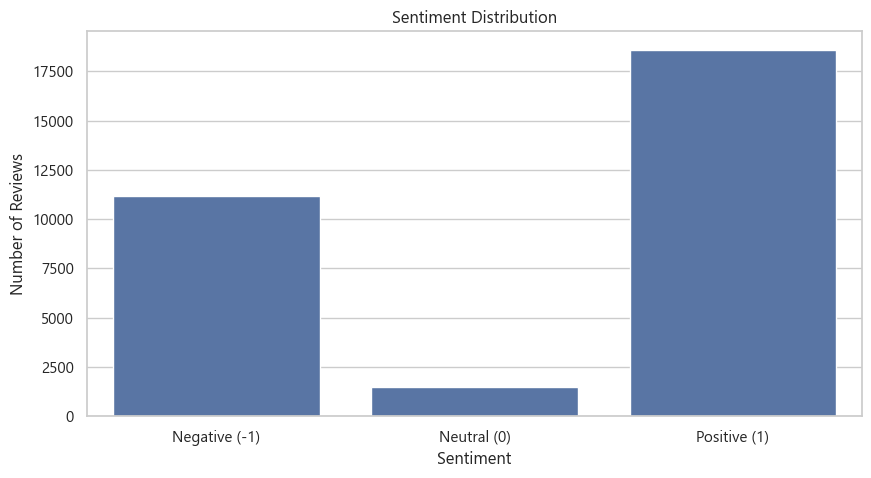

In [25]:
train = pd.read_csv('preprocessed_train.csv')

sentiment_counts = train['rating'].value_counts()

# Plotting the sentiment distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.xticks(ticks=[0, 1, 2], labels=['Negative (-1)', 'Neutral (0)', 'Positive (1)'])
plt.show()

### Review Length Distribution

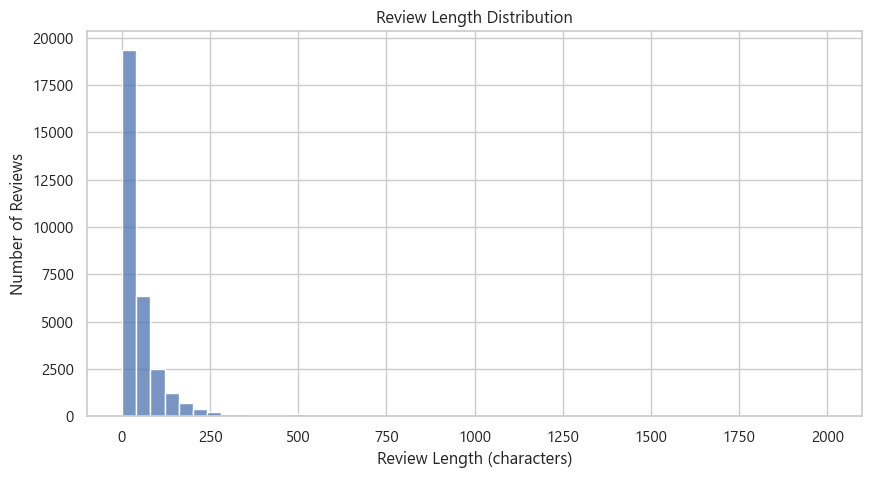

In [26]:
# Review Length Analysis
review_length = train['review_description'].apply(len)

# Plotting the distribution of review lengths
plt.figure(figsize=(10, 5))
sns.histplot(review_length, bins=50)
plt.title('Review Length Distribution')
plt.xlabel('Review Length (characters)')
plt.ylabel('Number of Reviews')
plt.show()

### Emojis Distribution

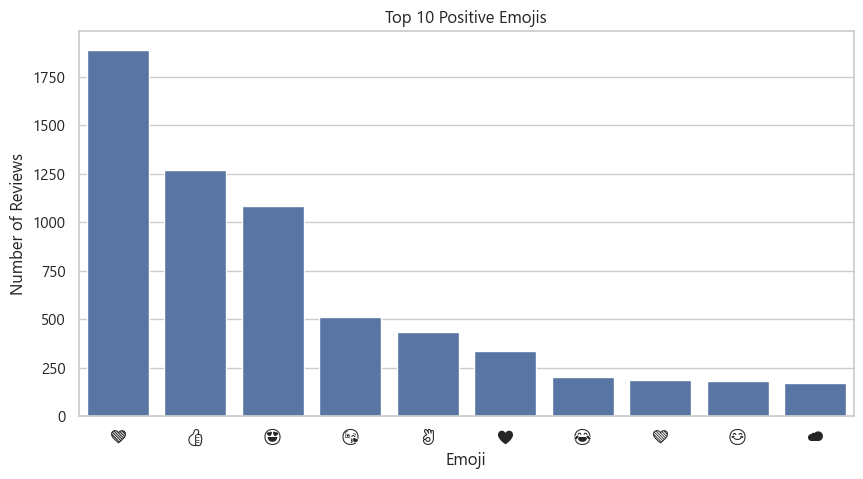

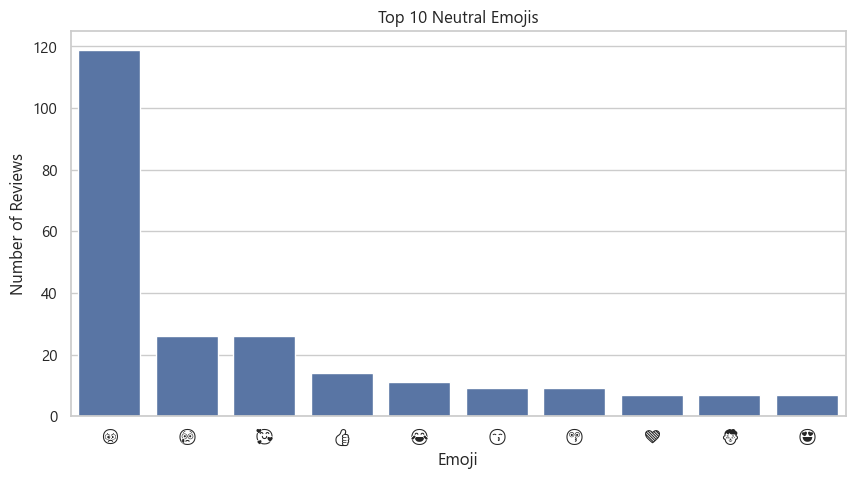

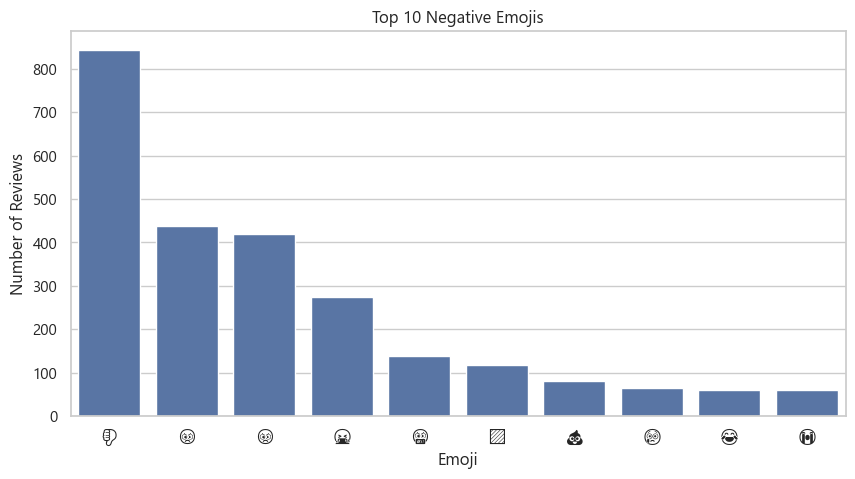

In [27]:
# Get emoji list
emoji_list = emoji.UNICODE_EMOJI['en'].keys()

# Function to extract emojis from text
def extract_emojis(text):
    return [c for c in text if c in emoji_list]

# Create separate DataFrames for each sentiment
positive_reviews = train[train['rating'] == 1]['review_description']
neutral_reviews = train[train['rating'] == 0]['review_description']
negative_reviews = train[train['rating'] == -1]['review_description']

# Extract emojis from reviews
positive_emojis = positive_reviews.apply(extract_emojis)
neutral_emojis = neutral_reviews.apply(extract_emojis)
negative_emojis = negative_reviews.apply(extract_emojis)

# Function to generate top emojis bar plot
def generate_top_emojis_bar_plot(emojis, title):
    emoji_counts = {}
    for emoji_list in emojis:
        for emoji in emoji_list:
            emoji_counts[emoji] = emoji_counts.get(emoji, 0) + 1
    sorted_emojis = dict(sorted(emoji_counts.items(), key=lambda item: item[1], reverse=True)[:10])
    
    # Set a font that includes emoji characters
    sns.set(style="whitegrid", font="Segoe UI Emoji")
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(sorted_emojis.keys()), y=list(sorted_emojis.values()))
    plt.title(title)
    plt.xlabel('Emoji')
    plt.ylabel('Number of Reviews')
    plt.show()

# Generate emoji bar plots for each sentiment
generate_top_emojis_bar_plot(positive_emojis, 'Top 10 Positive Emojis')
generate_top_emojis_bar_plot(neutral_emojis, 'Top 10 Neutral Emojis')
generate_top_emojis_bar_plot(negative_emojis, 'Top 10 Negative Emojis')

## Clean test data

In [ ]:
test = pd.read_csv('test.csv')

In [ ]:
test.head()

In [ ]:
test = clean_df(test)

In [ ]:
test.head()

In [ ]:
test.to_csv("preprocessed_test.csv", index=False)